In [21]:
# import system libs
# Install required packages
!pip install opencv-python-headless
!pip install scikit-learn
!pip install seaborn
!pip install tqdmimport os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# import data for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import load_img, array_to_img, img_to_array
from tensorflow.keras.optimizers import Adam
import random
from tqdm.notebook import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [22]:
def load_data(data_dir):
    images = []
    masks = []
    labels = []   # ✅ IMPORTANT — labels defined HERE

    classes = os.listdir(data_dir)

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        image_files = [
            f for f in os.listdir(class_dir)
            if f.endswith(".png") and "-mask" not in f
        ]

        for filename in image_files:
            image_path = os.path.join(class_dir, filename)
            mask_path = os.path.join(
                class_dir, filename.replace(".png", "-mask.png")
            )

            # Skip if mask missing
            if not os.path.exists(mask_path):
                continue

            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (128, 128))
            image = image / 255.0

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (128, 128))
            mask = (mask / 255.0 > 0.5).astype(np.float32)

            images.append(image)
            masks.append(mask)
            labels.append(class_name)  # ✅ labels used safely

    images = np.array(images)[..., np.newaxis]
    masks  = np.array(masks)[..., np.newaxis]

    print("Images:", images.shape)
    print("Masks :", masks.shape)
    print("Labels:", len(labels))

    return images, masks, labels


In [23]:
data_dir = "/Users/Hi/Downloads/Dataset"
images, masks, labels = load_data(data_dir)

Images: (1130, 128, 128, 1)
Masks : (1130, 128, 128, 1)
Labels: 1130


In [24]:
print(len(images[0][0]))
print(len(masks))
print(len(labels))

128
1130
1130


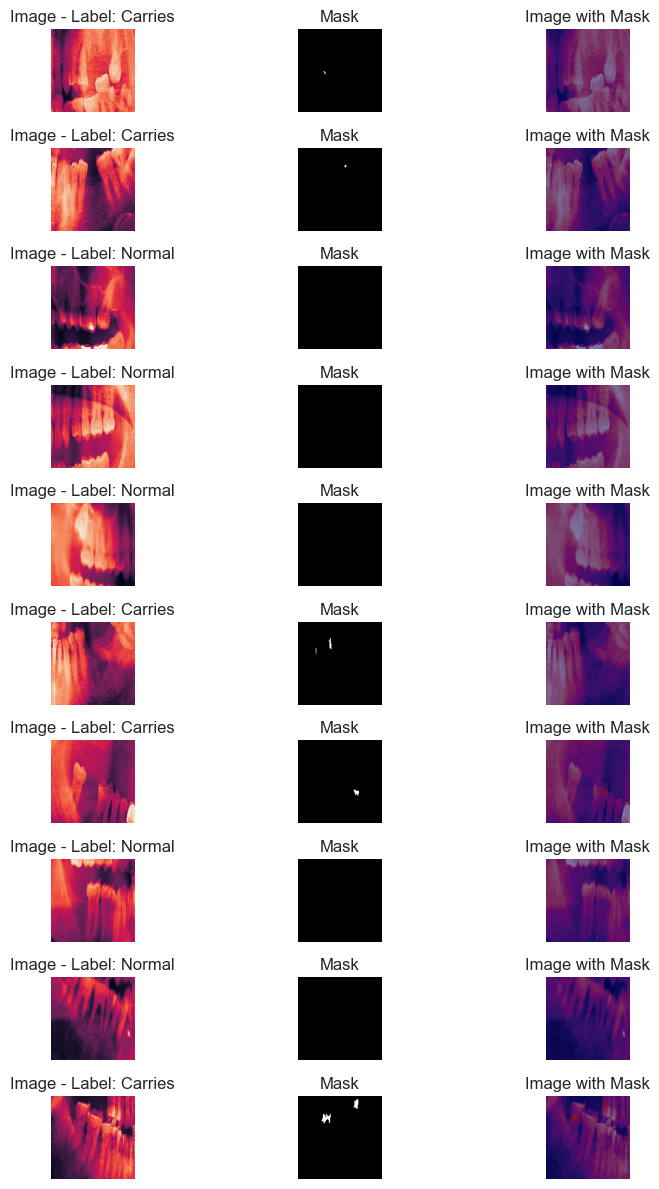

In [25]:
def plot_images_with_masks(images, masks, labels, num_images=10):
    # Select a random subset of indices
    indices = np.random.choice(len(images), num_images, replace=False)

    plt.figure(figsize=(15, 6 * num_images // 5))

    for i, idx in enumerate(indices, start=1):
        #Images
        plt.subplot(num_images, 6, 6 * i - 2)
        plt.imshow(images[idx])
        plt.axis('off')
        plt.title(f"Image - Label: {labels[idx]}")

        #Masks
        plt.subplot(num_images, 6, 6 * i - 1)
        plt.imshow(masks[idx], cmap='gray')
        plt.axis('off')
        plt.title("Mask")

        # Overlay mask on the image
        plt.subplot(num_images, 6, 6 * i)
        plt.imshow(images[idx])
        plt.imshow(masks[idx], cmap='jet', alpha=0.5)
        plt.axis('off')
        plt.title("Image with Mask")

    plt.tight_layout()
    plt.show()

plot_images_with_masks(images, masks, labels, num_images=10)


In [26]:
N = images.shape[0]

idx = np.arange(N)
np.random.seed(42)
np.random.shuffle(idx)

split = int(0.8 * N)

train_idx = idx[:split]
test_idx  = idx[split:]

train_images = images[train_idx].astype("float32")
test_images  = images[test_idx].astype("float32")

train_masks = masks[train_idx]
test_masks  = masks[test_idx]

print(train_images.shape)
print(test_images.shape)

(904, 128, 128, 1)
(226, 128, 128, 1)


In [38]:
def conv_block(x, out_ch, rate=1):
    x = tf.keras.layers.Conv2D(
        out_ch, 3, padding="same", dilation_rate=rate
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def RSU_L(x, out_ch, M_ch, num_layers, rate=2):
    hxin = conv_block(x, out_ch)

    hx = conv_block(hxin, M_ch)
    skips = [hx]

    for _ in range(num_layers - 2):
        hx = tf.keras.layers.MaxPool2D(2)(hx)
        hx = conv_block(hx, M_ch)
        skips.append(hx)

    hx = conv_block(hx, M_ch, rate=rate)

    skips = skips[::-1]
    hx = tf.keras.layers.Concatenate()([hx, skips[0]])
    hx = conv_block(hx, M_ch)

    for i in range(1, num_layers - 1):
        hx = tf.keras.layers.UpSampling2D(2, interpolation="bilinear")(hx)
        hx = tf.keras.layers.Concatenate()([hx, skips[i]])
        hx = conv_block(hx, M_ch)

    hx = conv_block(hx, out_ch)
    return tf.keras.layers.Add()([hx, hxin])

def RSU_4F(x, out_ch, M_ch):
    hxin = conv_block(x, out_ch)

    hx1 = conv_block(hxin, M_ch, rate=1)
    hx2 = conv_block(hx1, M_ch, rate=2)
    hx3 = conv_block(hx2, M_ch, rate=4)
    hx4 = conv_block(hx3, M_ch, rate=8)

    hx = tf.keras.layers.Concatenate()([hx4, hx3])
    hx = conv_block(hx, M_ch, rate=4)

    hx = tf.keras.layers.Concatenate()([hx, hx2])
    hx = conv_block(hx, M_ch, rate=2)

    hx = tf.keras.layers.Concatenate()([hx, hx1])
    hx = conv_block(hx, out_ch, rate=1)

    return tf.keras.layers.Add()([hx, hxin])

def u2net(shape, out_ch, M_ch, num_classes=1):
    inputs = tf.keras.layers.Input(shape)

    e1 = RSU_L(inputs, out_ch[0], M_ch[0], 7)
    p1 = tf.keras.layers.MaxPool2D((2, 2))(e1)

    e2 = RSU_L(p1, out_ch[1], M_ch[1], 6)
    p2 = tf.keras.layers.MaxPool2D((2, 2))(e2)

    e3 = RSU_L(p2, out_ch[2], M_ch[2], 5)
    p3 = tf.keras.layers.MaxPool2D((2, 2))(e3)

    e4 = RSU_L(p3, out_ch[3], M_ch[3], 4)
    p4 = tf.keras.layers.MaxPool2D((2, 2))(e4)

    e5 = RSU_4F(p4, out_ch[4], M_ch[4])
    p5 = tf.keras.layers.MaxPool2D((2, 2))(e5)

    b1 = RSU_4F(p5, out_ch[5], M_ch[5])
    b2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    d1 = tf.keras.layers.Concatenate()([b2, e5])
    d1 = RSU_4F(d1, out_ch[6], M_ch[6])
    u1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

    d2 = tf.keras.layers.Concatenate()([u1, e4])
    d2 = RSU_L(d2, out_ch[7], M_ch[7], 4)
    u2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

    d3 = tf.keras.layers.Concatenate()([u2, e3])
    d3 = RSU_L(d3, out_ch[8], M_ch[8], 5)
    u3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)

    d4 = tf.keras.layers.Concatenate()([u3, e2])
    d4 = RSU_L(d4, out_ch[9], M_ch[9], 6)
    u4 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

    d5 = tf.keras.layers.Concatenate()([u4, e1])
    d5 = RSU_L(d5, out_ch[10], M_ch[10], 7)

    
    y1 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d5)

    y2 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d4)
    y2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d3)
    y3 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d2)
    y4 = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d1)
    y5 = tf.keras.layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)

    y6 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(b1)
    y6 = tf.keras.layers.UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    y0 = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(y0)

    y0 = tf.keras.layers.Activation("sigmoid")(y0)
    y1 = tf.keras.layers.Activation("sigmoid")(y1)
    y2 = tf.keras.layers.Activation("sigmoid")(y2)
    y3 = tf.keras.layers.Activation("sigmoid")(y3)
    y4 = tf.keras.layers.Activation("sigmoid")(y4)
    y5 = tf.keras.layers.Activation("sigmoid")(y5)
    y6 = tf.keras.layers.Activation("sigmoid")(y6)

    model = tf.keras.models.Model(inputs, outputs=y0, name="U2-Net")
    return model

def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    M_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, M_ch, num_classes=num_classes)
    return model

def build_u2net_lite(input_shape, num_classes=1):
    out_ch = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    M_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    input_shape_with_channels = input_shape + (1,)
    model = u2net(input_shape_with_channels, out_ch, M_ch, num_classes=num_classes)
    return model

u2net_model = build_u2net_lite((128,128))

u2net_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

u2net_model.summary()

 Non-trainable params: 5,952 (23.25 KB)

In [30]:
opt = Adam(learning_rate=1e-3)
u2net_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
def get_callbacks():
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        "Dental_Segmentation_U2Net.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    return [reduce_lr, checkpoint, early_stop]

In [44]:
history = u2net_model.fit(
    train_images,
    train_masks,
    validation_data=(test_images, test_masks),
    batch_size=4,
    epochs=30,
    callbacks=get_callbacks()
)

Restoring model weights from the end of the best epoch: 13.


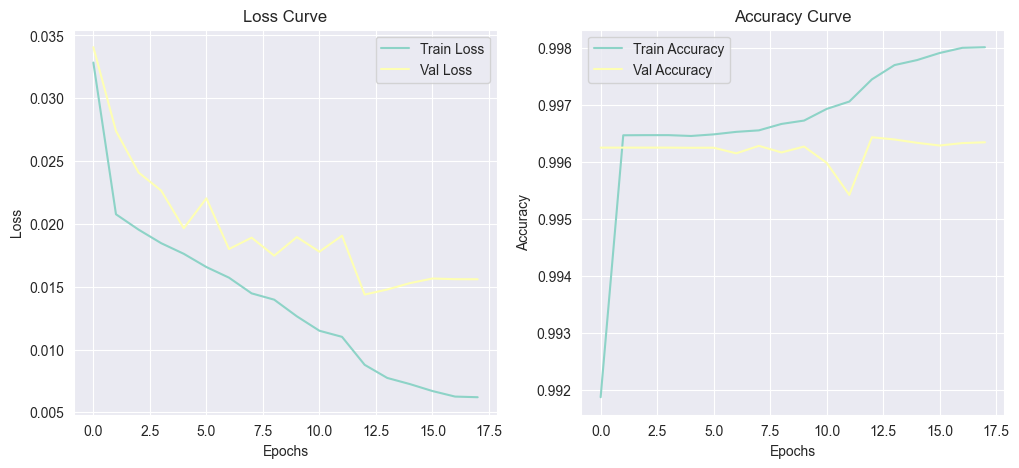

In [45]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [46]:
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)
encoded_labels = to_categorical(encoded_labels, num_classes=4)
train_images, test_images, train_labels, test_labels = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)
train_images = np.array(train_images).reshape(len(train_images),128,128)
test_images = np.array(test_images).reshape(len(test_images),128,128)
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(904, 128, 128)
(226, 128, 128)
(904, 4)
(226, 4)


In [47]:
def build_classification_model(base_model):
    
    u2net_base = Model(inputs=base_model.input, outputs=base_model.output)

    for layer in u2net_base.layers:
        layer.trainable = False

    flat_layer = Flatten()(u2net_base.output)
    dense_layer = Dense(256, activation='relu')(flat_layer)
    output_layer = Dense(4, activation='softmax')(dense_layer)

    classification_model = Model(inputs=base_model.input, outputs=output_layer)
    return classification_model

classification_model = build_classification_model(u2net_model)
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#classification_model.summary()

# Save the best model weights during training
checkpoint_filepath = 'classification_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=classification_model.h5

In [18]:
history = classification_model.fit(train_images, train_labels, validation_split = 0.2, batch_size = 16, epochs = 30, callbacks=model_checkpoint_callback)

Epoch 1/30
847/847 [==============================] - 60s 61ms/step - loss: 1.0782 - accuracy: 0.5823 - val_loss: 0.8891 - val_accuracy: 0.6135
Epoch 2/30
847/847 [==============================] - 49s 58ms/step - loss: 0.8592 - accuracy: 0.6283 - val_loss: 0.8628 - val_accuracy: 0.6171
Epoch 3/30
847/847 [==============================] - 49s 57ms/step - loss: 0.8257 - accuracy: 0.6436 - val_loss: 0.8853 - val_accuracy: 0.6129
Epoch 4/30
847/847 [==============================] - 49s 58ms/step - loss: 0.8166 - accuracy: 0.6498 - val_loss: 0.8716 - val_accuracy: 0.6230
Epoch 5/30
847/847 [==============================] - 49s 58ms/step - loss: 0.7868 - accuracy: 0.6676 - val_loss: 0.8634 - val_accuracy: 0.6244
Epoch 6/30
847/847 [==============================] - 49s 58ms/step - loss: 0.7704 - accuracy: 0.6732 - val_loss: 0.8249 - val_accuracy: 0.6383
Epoch 7/30
847/847 [==============================] - 49s 57ms/step - loss: 0.7547 - accuracy: 0.6804 - val_loss: 0.8412 - val_accuracy:

In [20]:
evaluation_result = classification_model.evaluate(test_images, test_labels)

In [22]:
accuracy = evaluation_result[1]
print(f'Model Accuracy on Test Data: {accuracy}')

Model Accuracy on Test Data: 0.6425702571868896
